# 计算机视觉课程作业
以下任务均在当前image-classifier.ipynb中执行，需要完整执行所有代码，并保存输出结果。完成任务后提交image-classifier.ipynb文件。
### 任务一：提升模型预测准确率
以下代码已经实现了基本的CIFAR-10图像分类。   
在不使用其他预训练模型下（即只能在CIFAR-10数据上从头训练模型），请通过数据增强、模型结构优化、更改优化策略（优化器，epoch，损失函数等）等方式提升模型预测准确率。   
<font color=red>注意：成绩会通过“Step 5: Evaluate model accuracy”的输出结果Average Acc进行评分，请勿更改step 5的代码，且需要完整执行所有代码。</font>

### 任务二：T-SNE
使用pytorch中的hook提取测试集“testloader”在模型中间层的特征表示，并使用T-SNE方法进行可视化。   
<font color=red>注意：可视化结果应当作为"Step 6: T-SNE Visualization"的输出结果。</font>

# 任务一：提升模型预测准确率

## Step 1: Download a dataset and preview images

A model is only as good as its dataset.

Training tools need lots of high-quality data to build accurate models. We'll use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 60,000 photos to build our image classifier. Get started by downloading the dataset with `torchvision` and previewing a handful of images from it.

Files already downloaded and verified
Files already downloaded and verified


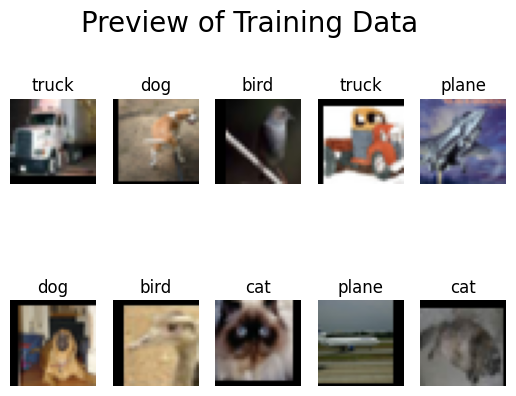

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

# Download the CIFAR-10 dataset to ./data
batch_size=10
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Data Augmentation and Preprocessing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

total_size = len(trainset)
train_size = int(0.9 * total_size)  # 90% for training
val_size = total_size - train_size  # 10% for validation
# Split the dataset into training and validation sets
trainset, valset = random_split(trainset, [train_size, val_size])

# Create data loaders for training and validation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)



# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    plt.title(classes[labels[i]])

plt.suptitle('Preview of Training Data', size=20)
plt.show()

# Step 2: Configure the neural network

Now that we have our dataset, we need to set up a neural network for PyTorch. Our neural network will transform an image into a description.

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

EPOCHS = 50

# Learning Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0.00001)

print("Your network is ready for training!")

Your network is ready for training!


# Step 3: Train the network and save model

PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [6]:
from tqdm import tqdm

print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    net.train()
    
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    net.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch + 1} - Loss: {running_loss / len(trainloader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%")
    scheduler.step()

# Save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Training...


Epoch 1 of 50: 100%|███████████████████████| 4500/4500 [00:37<00:00, 119.53it/s]


Epoch 1 - Loss: 2.3080, Validation Accuracy: 9.70%


Epoch 2 of 50: 100%|███████████████████████| 4500/4500 [00:38<00:00, 118.02it/s]


Epoch 2 - Loss: 2.3048, Validation Accuracy: 10.44%


Epoch 3 of 50: 100%|███████████████████████| 4500/4500 [00:39<00:00, 114.79it/s]


Epoch 3 - Loss: 2.3053, Validation Accuracy: 10.56%


Epoch 4 of 50: 100%|███████████████████████| 4500/4500 [00:37<00:00, 120.51it/s]


Epoch 4 - Loss: 2.3047, Validation Accuracy: 9.88%


Epoch 5 of 50: 100%|███████████████████████| 4500/4500 [00:38<00:00, 117.64it/s]


Epoch 5 - Loss: 2.3049, Validation Accuracy: 9.66%


Epoch 6 of 50: 100%|███████████████████████| 4500/4500 [00:38<00:00, 118.24it/s]


Epoch 6 - Loss: 2.3050, Validation Accuracy: 9.82%


Epoch 7 of 50: 100%|███████████████████████| 4500/4500 [00:38<00:00, 116.22it/s]


Epoch 7 - Loss: 2.3047, Validation Accuracy: 9.96%


Epoch 8 of 50: 100%|███████████████████████| 4500/4500 [00:38<00:00, 117.25it/s]


Epoch 8 - Loss: 2.3049, Validation Accuracy: 9.88%


Epoch 9 of 50: 100%|███████████████████████| 4500/4500 [00:38<00:00, 115.83it/s]


Epoch 9 - Loss: 2.3051, Validation Accuracy: 10.40%


Epoch 10 of 50: 100%|██████████████████████| 4500/4500 [00:39<00:00, 113.66it/s]


Epoch 10 - Loss: 2.3047, Validation Accuracy: 9.82%


Epoch 11 of 50: 100%|██████████████████████| 4500/4500 [00:42<00:00, 107.01it/s]


Epoch 11 - Loss: 2.3048, Validation Accuracy: 9.88%


Epoch 12 of 50: 100%|██████████████████████| 4500/4500 [00:41<00:00, 107.79it/s]


Epoch 12 - Loss: 2.3044, Validation Accuracy: 9.96%


Epoch 13 of 50: 100%|██████████████████████| 4500/4500 [00:42<00:00, 106.24it/s]


Epoch 13 - Loss: 2.3049, Validation Accuracy: 10.40%


Epoch 14 of 50: 100%|███████████████████████| 4500/4500 [00:50<00:00, 89.58it/s]


Epoch 14 - Loss: 2.3047, Validation Accuracy: 9.82%


Epoch 15 of 50: 100%|███████████████████████| 4500/4500 [00:58<00:00, 76.69it/s]


Epoch 15 - Loss: 2.3046, Validation Accuracy: 9.66%


Epoch 16 of 50: 100%|███████████████████████| 4500/4500 [01:01<00:00, 72.73it/s]


Epoch 16 - Loss: 2.3046, Validation Accuracy: 9.66%


Epoch 17 of 50: 100%|███████████████████████| 4500/4500 [01:07<00:00, 67.14it/s]


Epoch 17 - Loss: 2.3044, Validation Accuracy: 10.44%


Epoch 18 of 50: 100%|███████████████████████| 4500/4500 [01:10<00:00, 64.25it/s]


Epoch 18 - Loss: 2.3045, Validation Accuracy: 9.96%


Epoch 19 of 50: 100%|███████████████████████| 4500/4500 [01:08<00:00, 66.05it/s]


Epoch 19 - Loss: 2.3042, Validation Accuracy: 9.96%


Epoch 20 of 50: 100%|███████████████████████| 4500/4500 [01:07<00:00, 66.50it/s]


Epoch 20 - Loss: 2.3042, Validation Accuracy: 9.66%


Epoch 21 of 50: 100%|███████████████████████| 4500/4500 [01:07<00:00, 66.42it/s]


Epoch 21 - Loss: 2.3039, Validation Accuracy: 9.66%


Epoch 22 of 50: 100%|███████████████████████| 4500/4500 [01:08<00:00, 65.31it/s]


Epoch 22 - Loss: 2.3037, Validation Accuracy: 9.82%


Epoch 23 of 50: 100%|███████████████████████| 4500/4500 [01:08<00:00, 66.02it/s]


Epoch 23 - Loss: 2.3044, Validation Accuracy: 9.82%


Epoch 24 of 50: 100%|███████████████████████| 4500/4500 [01:09<00:00, 65.10it/s]


Epoch 24 - Loss: 2.3038, Validation Accuracy: 9.82%


Epoch 25 of 50: 100%|███████████████████████| 4500/4500 [01:06<00:00, 67.68it/s]


Epoch 25 - Loss: 2.3040, Validation Accuracy: 10.44%


Epoch 26 of 50: 100%|███████████████████████| 4500/4500 [01:06<00:00, 67.36it/s]


Epoch 26 - Loss: 2.3039, Validation Accuracy: 9.66%


Epoch 27 of 50:  36%|████████▎              | 1618/4500 [00:24<00:43, 66.40it/s]


KeyboardInterrupt: 

# Step 4: Test the trained model

Let's test our model!

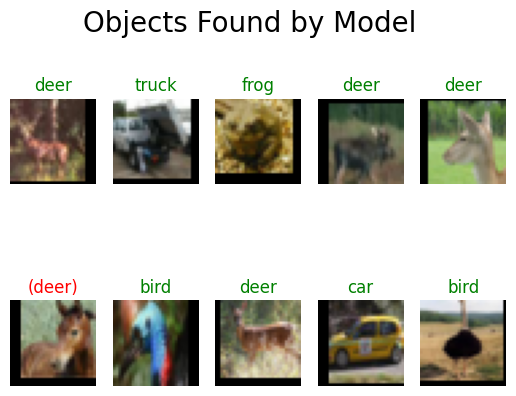

In [4]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloader)
images, labels = next(dataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [4]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
average_accuray = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    average_accuray.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print ('Average Acc:', np.mean(average_accuray))

Accuracy for class: plane is 82.1 %
Accuracy for class: car   is 89.8 %
Accuracy for class: bird  is 72.8 %
Accuracy for class: cat   is 61.0 %
Accuracy for class: deer  is 77.9 %
Accuracy for class: dog   is 69.5 %
Accuracy for class: frog  is 83.7 %
Accuracy for class: horse is 81.8 %
Accuracy for class: ship  is 88.6 %
Accuracy for class: truck is 87.2 %
Average Acc: 79.44


# 任务二：T-SNE

# Step 6: T-SNE Visualization

Visualize high-dimensional data in a low-dimensional space using T-SNE.